In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

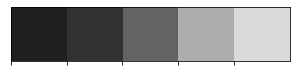

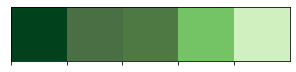

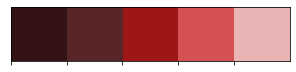

In [3]:


colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)



## Preprocessing Data ##

In [4]:
labels_of_tumor = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
print(labels_of_tumor)

['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']


In [17]:
from PIL import Image
#build preprocessing class
class Preprocessing():
    
    def __init__(self , img_size):
        self.X_train = []
        self.X_test = []
        self.y_train = []
        self.y_test = []
        self.img_size = img_size
        
    def getTraining(self, labels_of_tumor):
        for i in labels_of_tumor:
            path_training = os.path.join('./brain-tumor-class-mri','Training' , i)
            for j in tqdm(os.listdir(path_training)):
                img = cv2.imread(os.path.join(path_training , j)) #get the name of the folder path
                img = cv2.resize(img , (self.img_size , self.img_size)) #resizing image to image size parameter
                self.X_train.append(img)
                self.y_train.append(i)

    def getTesting(self, labels_of_tumor):
        for i in labels_of_tumor:
            path_testing = os.path.join('./brain-tumor-class-mri','Testing' , i)
            for j in tqdm(os.listdir(path_testing)):
                img = cv2.imread(os.path.join(path_testing , j)) #get the name of the folder path
                img = cv2.resize(img , (self.img_size , self.img_size)) #resizing image to image size parameter
                self.X_train.append(img)
                self.y_train.append(i)
                
    def returnSplitArrayOfTrain_Test(self):
        self.X_train = np.array(self.X_train)        
        self.y_train = np.array(self.y_train)
        self.X_train, self.y_train = shuffle(self.X_train,self.y_train, random_state=101)
        self.X_train,self.X_test,self.y_train,self.y_test = train_test_split(self.X_train,self.y_train, test_size=0.1,random_state=101)
        print(self.X_train.shape , self.y_train.shape, self.X_test.shape , self.y_test.shape)
        return self.X_train , self.y_train, self.X_test , self.y_test
    
    def oneHotEncoding(self , y_train, y_test, labels_of_tumor): #Performing One Hot Encoding on the labels after converting it into numerical values
        #Training
        y_train_nw = []
        for i in y_train:
            y_train_nw.append(labels_of_tumor.index(i))
        self.y_train = y_train_nw
        self.y_train = tf.keras.utils.to_categorical(self.y_train)
        
        #Testing
        y_test_nw = []
        for j in y_test:
            y_test_nw.append(labels_of_tumor.index(j))
        self.y_test = y_test_nw
        self.y_test = tf.keras.utils.to_categorical(self.y_test)
        
        return self.y_train, self.y_test
        


In [18]:
#Build Transfert Learning Model 

class buildModel():
    
    def __init__(self): 
        
        #init based EfficientNetB0 Model 
        self.efficienNetBasedModel = None
        self.model = None
        
    def buildModel(self , model_type , image_size): 
        
        #EfficientNetB0 model which will use the weights from the ImageNet dataset.
        if "EfficientNetB0" == model_type:
            self.efficienNetBasedModel = EfficientNetB0(
                                                weights='imagenet',
                                                include_top=False,
                                                input_shape=(image_size,image_size,3))
        
        self.model = self.efficienNetBasedModel.output
        self.model = tf.keras.layers.GlobalAveragePooling2D()(self.model)
        self.model = tf.keras.layers.Dropout(rate=0.5)(self.model)
        self.model = tf.keras.layers.Dense(4,activation='softmax')(self.model)
        self.model = tf.keras.models.Model(inputs=self.efficienNetBasedModel.input, outputs = self.model)
        
        return self.model if self.model != None else "undefined"
    
    def training(self , loss, optimize ,epochs_number,batch_size, xtrain, ytrain):
        
        tensorboard = TensorBoard(log_dir = 'logs')
        checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
        self.model.compile(loss=loss,optimizer = optimize , metrics= ['accuracy'])
        self.model.fit(xtrain,ytrain,validation_split=0.1, epochs =epochs_number, verbose=1, 
                       batch_size=batch_size,callbacks=[tensorboard,checkpoint,reduce_lr])
        
        return self.model



In [19]:
#init instance of Preprocessing class
obj_processing = Preprocessing(150)
#get training and testing folders
obj_processing.getTraining(labels_of_tumor) #Training
obj_processing.getTesting(labels_of_tumor)  #Testing
X_train , y_train , X_test, y_test = obj_processing.returnSplitArrayOfTrain_Test() #get Array 
#print(y_train.shape)

100%|████████████████████████████████████████████████████| 74/74 [00:00<00:00, 310.21it/s]


(2937, 150, 150, 3) (2937,) (327, 150, 150, 3) (327,)


glioma_tumor
glioma_tumor
glioma_tumor
no_tumor
no_tumor
no_tumor
glioma_tumor
meningioma_tumor
no_tumor
meningioma_tumor
no_tumor
meningioma_tumor
glioma_tumor
meningioma_tumor
pituitary_tumor
meningioma_tumor
no_tumor
meningioma_tumor
pituitary_tumor
meningioma_tumor
no_tumor
meningioma_tumor
no_tumor
meningioma_tumor
meningioma_tumor
meningioma_tumor
glioma_tumor
pituitary_tumor
no_tumor
pituitary_tumor
no_tumor
pituitary_tumor
glioma_tumor
pituitary_tumor
pituitary_tumor
pituitary_tumor


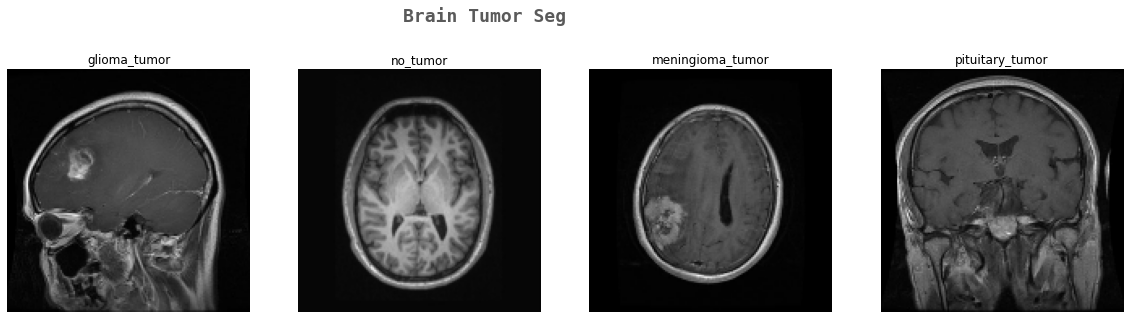

In [20]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Brain Tumor Seg',size=18,fontweight='bold',fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels_of_tumor:
    j=0
    while True :
        print(y_train[j])
        print(i)
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1



### Performing One Hot Encoding  ###


In [24]:
y_train , y_test = obj_processing.oneHotEncoding(y_train , y_test , labels_of_tumor)




### Transfer Learning


In [25]:
#call Model 
model = buildModel()
model_generated = model.buildModel('EfficientNetB0' , obj_processing.img_size)


model_generated.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 150, 150, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 150, 150, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [27]:
trained_model = model.training('categorical_crossentropy', 'Adam' ,12, 32 ,X_train, y_train)

2022-08-28 23:21:06.065373: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-08-28 23:21:06.065434: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-08-28 23:21:06.066663: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Epoch 1/12


2022-08-28 23:21:08.043602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/83 [..............................] - ETA: 6:44 - loss: 0.0316 - accuracy: 1.0000

2022-08-28 23:21:11.211283: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-08-28 23:21:11.211302: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


 2/83 [..............................] - ETA: 59s - loss: 0.0884 - accuracy: 0.9531 

2022-08-28 23:21:12.102350: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-28 23:21:12.108321: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-08-28 23:21:12.112888: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_08_28_23_21_12
2022-08-28 23:21:12.114926: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_08_28_23_21_12/MacBook-Pro-de-ZAHR-EDDINE.local.trace.json.gz
2022-08-28 23:21:12.118376: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_08_28_23_21_12
2022-08-28 23:21:12.118660: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_08_28_23_21_12/MacBook-Pro-de-ZAHR-EDDINE.local.memory_profile

83/83 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.9432

2022-08-28 23:21:53.610658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 50s 547ms/step - loss: 0.1764 - accuracy: 0.9432 - val_loss: 5.6171 - val_accuracy: 0.4796

Epoch 00001: val_accuracy improved from -inf to 0.47959, saving model to effnet.h5
Epoch 2/12
83/83 [==============================] - 42s 503ms/step - loss: 0.1444 - accuracy: 0.9542 - val_loss: 0.4319 - val_accuracy: 0.9116

Epoch 00002: val_accuracy improved from 0.47959 to 0.91156, saving model to effnet.h5
Epoch 3/12
83/83 [==============================] - 42s 501ms/step - loss: 0.1028 - accuracy: 0.9675 - val_loss: 0.3628 - val_accuracy: 0.9184

Epoch 00003: val_accuracy improved from 0.91156 to 0.91837, saving model to effnet.h5
Epoch 4/12
83/83 [==============================] - 42s 501ms/step - loss: 0.0894 - accuracy: 0.9694 - val_loss: 0.2022 - val_accuracy: 0.9524

Epoch 00004: val_accuracy improved from 0.91837 to 0.95238, saving model to effnet.h5
Epoch 5/12
83/83 [==============================] - 42s 500ms/step - loss: 0.0577 - accuracy: 

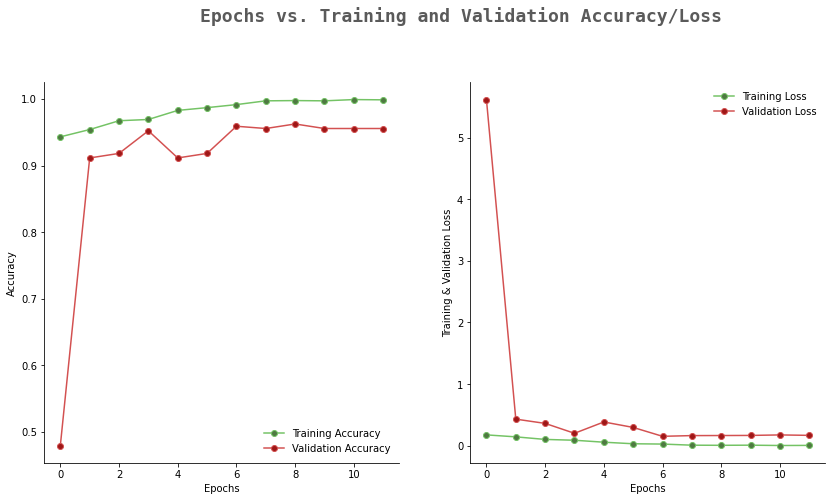

In [28]:

history = trained_model.history

filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()



In [29]:
pred = trained_model.predict(X_test)
pred = np.argmax(pred,axis=1)
yTestNew = np.argmax(y_test,axis=1)

2022-08-29 00:16:45.931546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [30]:

print(classification_report(yTestNew,pred))


              precision    recall  f1-score   support

           0       0.96      0.92      0.94        93
           1       1.00      1.00      1.00        51
           2       0.92      0.94      0.93        96
           3       0.98      0.99      0.98        87

    accuracy                           0.96       327
   macro avg       0.96      0.96      0.96       327
weighted avg       0.96      0.96      0.96       327



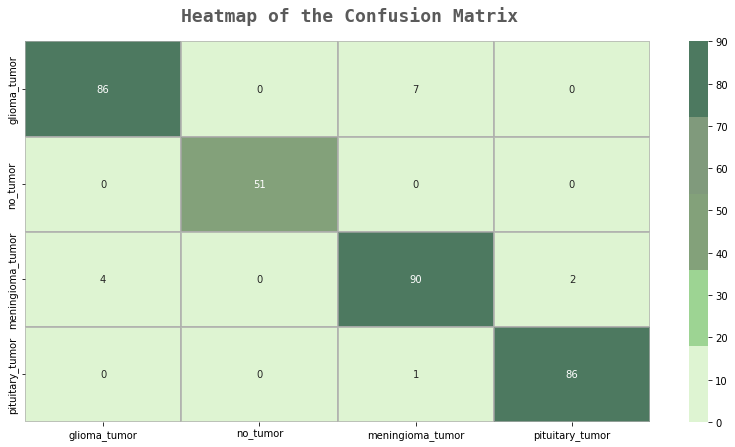

In [31]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(yTestNew,pred),ax=ax,xticklabels=labels_of_tumor,yticklabels=labels_of_tumor,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()


In [32]:
def img_pred(upload):
    
 
    img = cv2.imread(os.path.join('./brain-tumor-class-mri/' , 'mypredict.jpg'))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = trained_model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')


In [36]:
img_pred(None)


The model predicts that there is no tumor


In [35]:


button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])